In [36]:
# Data Handling
import pandas as pd

# Text Cleaning & Normalization
import re
import string

# Language Detection
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# Alternative: `langid` (if `langdetect` is unreliable)
import langid 

# Stopwords & Lemmatization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


# Handling Contractions
import contractions

# Emoji Handling (Optional)
import emoji

# Progress Bar (for large datasets)
from tqdm import tqdm

# BERT (Sentiment Analysis)
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
from tqdm import tqdm

# For Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [25]:
# Load the dataset
file_path = '/Users/bengreenes/Desktop/Babson/Spring25/OIM7502/Data/trump_updated_debate.csv'
df = pd.read_csv(file_path)

print(df.head())  # View first few rows
print(df.info())  # Check data types and missing values
print(df.columns) # Check Column Name

               User ID             Tweet ID  \
0             88236719  1833309413073162489   
1  1609990069590568961  1833309412720840970   
2  1535880797957238785  1833309412598903146   
3            182125474  1833309412544680222   
4  1223775310166069249  1833309412506615986   

                                               Tweet  \
0  RT @Richard_ezio: I want to tell the truth abo...   
1  RT @RBReich: Over the weekend, Donald Trump th...   
2                               @The_Trump_Train YES   
3  RT @KamalaHQLies: THE LIE: Donald Trump called...   
4  RT @pesach_lattin: So the FBI agent who testif...   

                  Created at  Retweets  Replies  Likes  Quotes  Source  
0  2024-09-10 00:59:59+00:00      5150        0      0       0     NaN  
1  2024-09-10 00:59:59+00:00      4769        0      0       0     NaN  
2  2024-09-10 00:59:59+00:00         0        0      3       0     NaN  
3  2024-09-10 00:59:59+00:00       509        0      0       0     NaN  
4  2024-09-10 0

In [30]:
# Step 1: Remove Duplicates and Retweets 
# Remove Duplicates
df = df.drop_duplicates(subset=['Tweet'], keep='first')

# Remove Retweets (tweets that start with "RT @username:")
df = df[~df['Tweet'].str.startswith("RT @")]

# Display results
print(f"Dataset size after duplicate & retweet removal: {df.shape[0]} rows")

Dataset size after duplicate & retweet removal: 850 rows


In [32]:
#Step 2: Filtering for English Tweets

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:  # Handle cases where detection fails
        return "unknown"

# Apply language detection
df['language'] = df['Tweet'].apply(detect_language)

# Filter for English tweets
df = df[df['language'] == 'en']

# Display results
print(df['Tweet'].head())
print(f"Dataset size after filtering non-English tweets: {df.shape[0]} rows")

2                                  @The_Trump_Train YES
6                  @WeThePeople021 Not as many as Trump
9     @Katrina4AZ @Srk1951mn Biggs is a liar! We all...
13      @SallyDeal4 Complete false  trump is everything
27    @Arriadna @PpollingNumbers You’re going to hav...
Name: Tweet, dtype: object
Dataset size after filtering non-English tweets: 755 rows


In [34]:
#Step 3: Text Normalization

# Function to clean tweets while keeping mentions with "Trump"
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|bit.ly\S+", "", text)  # Remove URLs
    text = re.sub(r"@(?!.*Trump).*?\b", "", text, flags=re.IGNORECASE)  # Remove mentions EXCEPT those containing "Trump"
    text = contractions.fix(text)  # Expand contractions
    return text.strip()

# Apply cleaning function
df['Tweet'] = df['Tweet'].apply(clean_text)

# Display sample cleaned tweets
print(df['Tweet'].head())
print(f"Dataset size after text normalization: {df.shape[0]} rows")

2                                  @The_Trump_Train YES
6                  @WeThePeople021 Not as many as Trump
9     @Katrina4AZ @Srk1951mn Biggs is a liar! We all...
13      @SallyDeal4 Complete false  trump is everything
27    @Arriadna @PpollingNumbers You are going to ha...
Name: Tweet, dtype: object
Dataset size after text normalization: 755 rows


In [6]:
# Step 4: Stopwords Removal & Lemmatization

# Initialize stopwords set and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean stopwords and lemmatize words
def preprocess_text(text):
    words = word_tokenize(text)  # Tokenize text into words
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words or word.startswith("@")]  # Keep @mentions
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]  # Apply lemmatization
    return " ".join(lemmatized_words)  # Reconstruct cleaned text

# Apply preprocessing to tweets
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Display a few cleaned tweets
print(df['Tweet'].head())
print(f"Dataset size after stopwords removal & lemmatization: {df.shape[0]} rows")

2                                 @ the_trump_train yes
6                           @ wethepeople021 many trump
9     @ katrina4az @ srk1951mn biggs liar ! saw trum...
13         @ sallydeal4 complete false trump everything
27    @ arriadna @ ppollingnumbers going donald j tr...
Name: Tweet, dtype: object
Dataset size after stopwords removal & lemmatization: 755 rows


In [7]:
# Step 5: Add a Flag to Replies

df['is_reply'] = df['Tweet'].str.startswith("@").astype(int)  # 1 if reply, 0 if not
print(df[['Tweet', 'is_reply']].head())  # Preview flagged data

                                                Tweet  is_reply
2                               @ the_trump_train yes         1
6                         @ wethepeople021 many trump         1
9   @ katrina4az @ srk1951mn biggs liar ! saw trum...         1
13       @ sallydeal4 complete false trump everything         1
27  @ arriadna @ ppollingnumbers going donald j tr...         1


In [8]:
# Step 6: VADER sentiment analysis
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis
def get_vader_sentiment(text):
    scores = sia.polarity_scores(str(text))  # Convert to string to handle NaN values
    sentiment_label = "Neutral"
    
    if scores['compound'] >= 0.05:
        sentiment_label = "Positive"
    elif scores['compound'] <= -0.05:
        sentiment_label = "Negative"
    
    return sentiment_label, scores['compound'], scores['pos'], scores['neu'], scores['neg']

# Load dataset
file_path = '/Users/bengreenes/Desktop/Babson/Spring25/OIM7502/Data/trump_updated_debate.csv'  # Change this to your actual file path
df = pd.read_csv(file_path)

# Apply sentiment analysis
sentiments = []
compounds = []
positives = []
neutrals = []
negatives = []

for tweet in tqdm(df["Tweet"].tolist(), desc="Processing Tweets"):
    sentiment, compound, pos, neu, neg = get_vader_sentiment(tweet)
    sentiments.append(sentiment)
    compounds.append(compound)
    positives.append(pos)
    neutrals.append(neu)
    negatives.append(neg)

# Add results to DataFrame
df["sentiment"] = sentiments
df["compound"] = compounds
df["positive"] = positives
df["neutral"] = neutrals
df["negative"] = negatives

# Save results to CSV
output_file = "vader_sentiment_results.csv"
df.to_csv(output_file, index=False)
print(f"Sentiment analysis results saved to '{output_file}'")

# Display the first few rows
print(df.head())


Processing Tweets: 100%|██████████████████| 4795/4795 [00:00<00:00, 8764.88it/s]

Sentiment analysis results saved to 'vader_sentiment_results.csv'
               User ID             Tweet ID  \
0             88236719  1833309413073162489   
1  1609990069590568961  1833309412720840970   
2  1535880797957238785  1833309412598903146   
3            182125474  1833309412544680222   
4  1223775310166069249  1833309412506615986   

                                               Tweet  \
0  RT @Richard_ezio: I want to tell the truth abo...   
1  RT @RBReich: Over the weekend, Donald Trump th...   
2                               @The_Trump_Train YES   
3  RT @KamalaHQLies: THE LIE: Donald Trump called...   
4  RT @pesach_lattin: So the FBI agent who testif...   

                  Created at  Retweets  Replies  Likes  Quotes  Source  \
0  2024-09-10 00:59:59+00:00      5150        0      0       0     NaN   
1  2024-09-10 00:59:59+00:00      4769        0      0       0     NaN   
2  2024-09-10 00:59:59+00:00         0        0      3       0     NaN   
3  2024-09-10 00:5

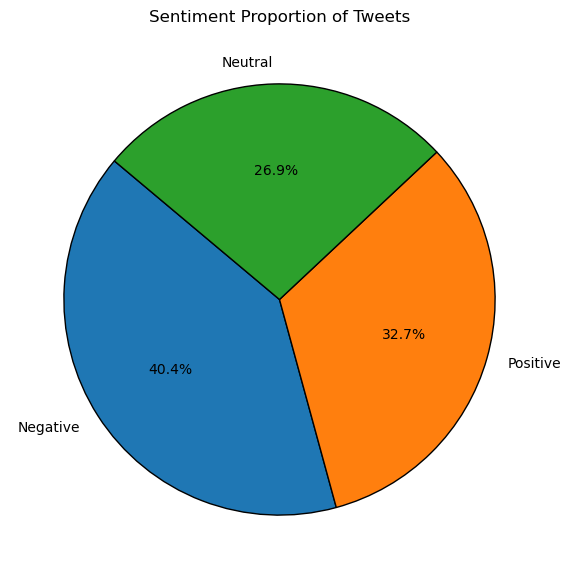

In [9]:
# Create a Pie Chart

# Count occurrences of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Create Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Sentiment Proportion of Tweets")
plt.show()

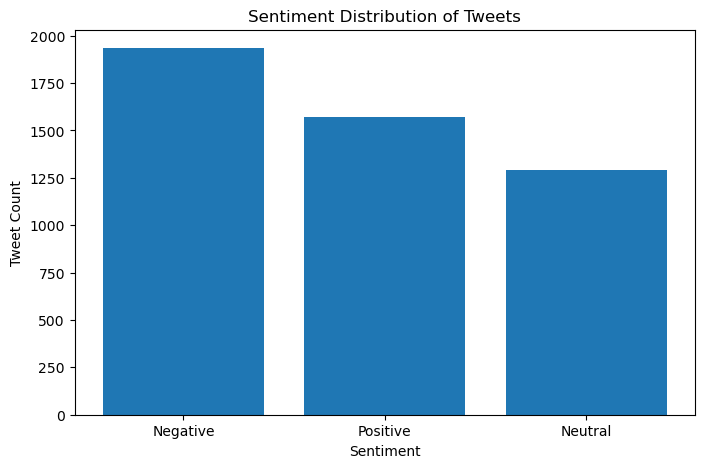

In [10]:
# Create a Bar Chart

# Count occurrences of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Plot the bar chart
plt.figure(figsize=(8,5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.title("Sentiment Distribution of Tweets")
plt.xticks(rotation=0)
plt.show()

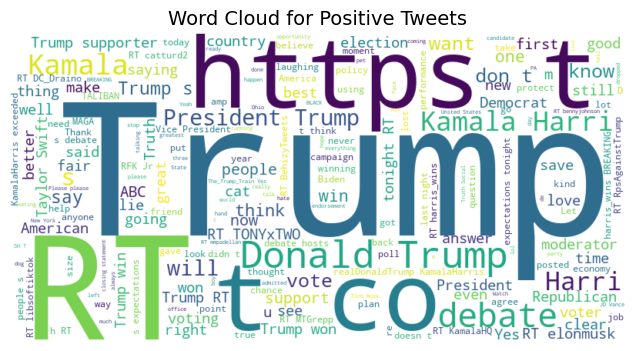

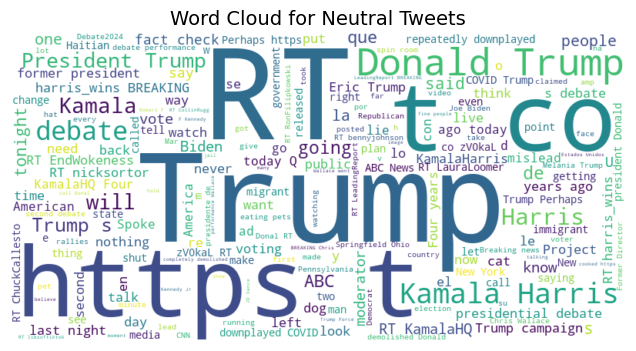

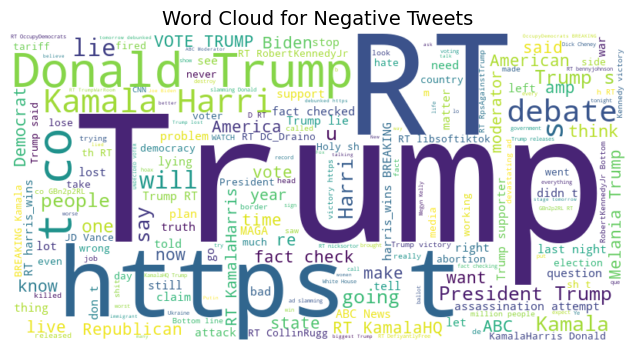

In [11]:
# Create a Word Clouds

# Function to generate and display a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(" ".join(text))
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Generate word clouds for each sentiment category
for sentiment in ["Positive", "Neutral", "Negative"]:
    sentiment_text = df[df["sentiment"] == sentiment]["Tweet"]
    generate_wordcloud(sentiment_text, f"Word Cloud for {sentiment} Tweets")

<Figure size 1000x500 with 0 Axes>

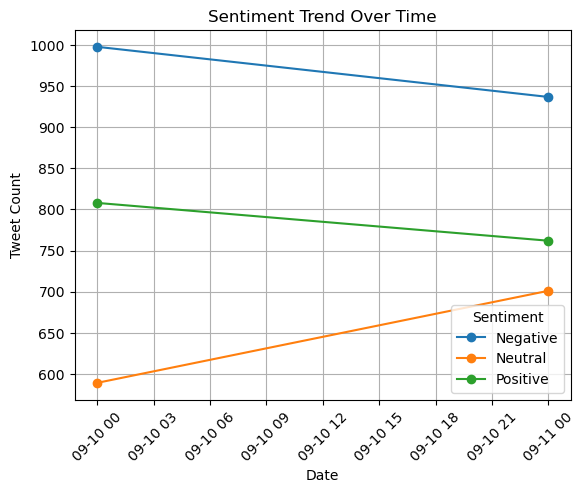

In [12]:
# Create a Line Chart (Sentiment Trend Over Time)

# Ensure timestamp column is in datetime format
df["Created at"] = pd.to_datetime(df["Created at"])  # Change column name if needed

# Set timestamp as index (optional but useful for resampling)
df = df.set_index("Created at")

# Resample by hour and count sentiment occurrences
sentiment_trend = df.groupby([df.index.date, "sentiment"]).size().unstack()

# Plot Sentiment Trend Over Time
plt.figure(figsize=(10, 5))
sentiment_trend.plot(marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.title("Sentiment Trend Over Time")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.grid()

plt.show()